In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
random.seed(5)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace



# Transformer Model Class

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, 
                 embed_size, 
                 heads,
                 dropout = 0.1):
        super(SelfAttention, self).__init__()
        self.embed_size= embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert (embed_size / heads  == self.head_dim ), "The ratio embed_size / heads should be an integer"

        self.values =nn.Linear(self.embed_size, self.embed_size, bias = False )
        self.keys =nn.Linear(self.embed_size, self.embed_size, bias = False )
        self.queries =nn.Linear(self.embed_size, self.embed_size, bias = False )
        self.fc_out =nn.Linear(self.embed_size, self.embed_size )

        self.dropout = nn.Dropout(dropout)


    def forward(self, values, keys, queries, mask = None):
        N = queries.shape[0]

        value_len, key_len, query_len =  values.shape[1], keys.shape[1] , queries.shape[1]
        values = self.queries(values)
        keys = self.queries(keys)
        queries = self.queries(queries)

        # Separates value, keys and queries embedding into heads with size equal size
        values = values.reshape(N, value_len, self.heads, self.head_dim )   # (N, value_len, heads, head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim )         # (N, key_len, heads, head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim ) # (N, query_len, heads, head_dim)

        # 1- Multiply queries with keys
        # queries shape: (N, query_len,  self.heads, self.head_dim ) (nqhd)
        # keys shape: (N, key_len,  self.heads, self.head_dim )  (nkhd)
        # queries_by_keys: (N, self.heads, query_len, key_len) (nhqk)
        queries_by_keys = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            queries_by_keys= queries_by_keys.masked_fill(mask==0, float("-1e10"))  #-1e10
            # print(queries_by_keys)

        attention = torch.softmax(queries_by_keys / (self.embed_size ** (1/2)), dim = -1) # softmax across keys
        attention = self.dropout(attention)
        
        # 2- Multiply attention with values
        # attention: (N, self.heads, query_len, key_len) (nhql)
        # values shape: (N, value_len,  self.heads, self.head_dim )  (nlhd)
        # attention_by_values: (N, query_len,  self.heads, self.head_dim )  (nqhd)
        # attention_by_values =  torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
        #     N, query_len, self.embed_size )
        
        attention_by_values =  torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.embed_size )

        out = self.fc_out(attention_by_values)
        return(out)
    
class TransformerBlock(nn.Module):
    def __init__(self, 
                 embed_size, 
                 heads, 
                 dropout, 
                 expansion):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, expansion * embed_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(expansion * embed_size, embed_size))

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention)) + query 
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward )) +  x  
        return out


class Encoder(nn.Module):
    def __init__(self, 
                 source_vocab_size, 
                 embed_size, 
                 num_layers,
                 heads,
                 device,
                 expansion,
                 dropout,
                 max_sentence_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(source_vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_sentence_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, 
                                heads, 
                                dropout, 
                                expansion) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)#.to(device)

    def forward(self, x, mask):
        #print('Encoder forward')
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N,seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.pos_embedding(positions)) 
        )

        # loop over each TransformerBlock
        for layer in self.layers:
            out = layer(out, out, out, mask)
        return out 

class DecoderBlock(nn.Module):
    def __init__(self, 
                embed_size, 
                heads,
                expansion,
                dropout,
                device):
        super(DecoderBlock, self).__init__() 
        # self.device = device
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.tranformer_block = TransformerBlock(embed_size, 
                                                heads, 
                                                dropout, 
                                                expansion)
                                                
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, query, source_mark, target_mask):
        attention = self.attention(x, x, x, target_mask)
        query = self.dropout(self.norm(attention )) +x     #####
        out = self.tranformer_block(value, key, query, source_mark)
        return out
    

class Decoder(nn.Module):
    def __init__(self, 
                 target_vocab_size, 
                 embed_size, 
                 num_layers,
                 heads,
                 device,
                 expansion,
                 dropout,
                 max_sentence_length):
        super(Decoder, self).__init__() 
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(target_vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_sentence_length, embed_size)
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, 
                                heads, 
                                expansion,
                                dropout, 
                                device) for _ in range(num_layers)]
        )
        self.fc_out = nn.Linear(embed_size, target_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x , enc_out, source_mask, target_mask):
        #print('decoder forward')
        N, seq_length = x.shape

        positions = torch.arange(0, seq_length).expand(N,seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.pos_embedding(positions)) 

        # loop over each DecoderBlocks
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, enc_out,  source_mask, target_mask )

        # (N, max_sentence_length, embedding_size) --> (N, max_sentence_length, target_vocab_size)
        out = self.fc_out(x) 
        return out

class Transformer(nn.Module):
    def __init__(self, 
            target_vocab_size, 
            source_vocab_size,
            target_pad_index,
            source_pad_index,
            embed_size, 
            num_layers,
            heads,
            device,
            expansion,
            dropout,
            max_sentence_length,
            debug = False):
        
        super(Transformer, self).__init__()
        self.encoder = Encoder(source_vocab_size, 
                                embed_size, 
                                num_layers,
                                heads,
                                device,
                                expansion,
                                dropout,
                                max_sentence_length)#.to(device)
        
        self.decoder = Decoder(target_vocab_size, 
                                embed_size, 
                                num_layers,
                                heads,
                                device,
                                expansion,
                                dropout,
                                max_sentence_length)#.to(device)
        self.embed_size = embed_size
        self.device = device
        self.source_pad_index = source_pad_index
        self.target_pad_index = target_pad_index
        self.linear_out = nn.Linear(embed_size, target_vocab_size)#.to(device)
        self.debug  = debug

    def make_source_mask(self, source):

        # source_mask shape : (N, 1, 1, source_length)
        source_mask = (source != self.source_pad_index).unsqueeze(1).unsqueeze(2)  

        #print( 'source_mask\n' , source_mask)
        return source_mask.to(self.device)
    
    def make_target_mask(self, target):
        N, target_len = target.shape
        # target mask : (1, 1 seq_len) &  (N, 1, seq_length, seq_length )
        target_mask = \
            ((target != self.target_pad_index).unsqueeze(1).int().to(self.device) & torch.tril(torch.ones((N, target_len, target_len)), diagonal=0).int().to(self.device)).unsqueeze(1)  

        return target_mask.to(self.device)
        
         # ((target_test != 0).unsqueeze(1).int() & torch.triu(torch.ones((3, 8, 8)), diagonal=1).type(torch.int)).unsqueeze(1) # (1, seq_len) & (1, seq_len, seq_len),


    def forward(self, source, target):
        source_mask = self.make_source_mask(source)
        target_mask = self.make_target_mask(target)
        enc_src = self.encoder(source, source_mask)
        out = self.decoder(target, enc_src, source_mask, target_mask)
        if self.debug:
            print('----------------------------')
            print('source_mask:\n' , source_mask, source_mask.shape, '\n ---------------------------------------')
            print('target_mask:\n' , target_mask,  target_mask.shape,'\n---------------------------------------')
            print('source:\n' , source,      source.shape,     '\n---------------------------------------')
            print('target:\n' , target,    target.shape,       '\n---------------------------------------')
        return out

In [3]:
source_test = torch.tensor([[5, 3, 4, 5, 6, 8, 2, 7, 8, 5, 8, 9],
        [9, 5, 3, 8, 7, 6, 5, 4, 6, 6, 0, 0],
        [8, 3, 8, 7, 4, 2, 6, 5, 3, 9, 6, 0]], device= 'cpu')

target_test = torch.tensor([[4, 1, 2, 1, 6, 1, 0, 0, 0, 0, 0, 0],
        [6, 2, 6, 6, 7, 2, 9, 6, 3, 4, 0, 0],
        [9, 6, 8, 4,  8, 6, 9, 9, 2, 7, 0, 0]], device= 'cpu')

In [4]:
((target_test != 0).unsqueeze(1)).int()

tensor([[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]],

        [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]],

        [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]], dtype=torch.int32)

In [5]:
#torch.triu(torch.ones((3, 12, 12)), diagonal=1).expand(1).shape

In [6]:
t = torch.ones(2,2,4,4)
mask =torch.tensor([[1,1,1,0],[1,1,0,0]]).unsqueeze(1).unsqueeze(1)
mask.shape, t.shape

(torch.Size([2, 1, 1, 4]), torch.Size([2, 2, 4, 4]))

In [7]:
t.masked_fill_(mask == 0, -55)[0]

tensor([[[  1.,   1.,   1., -55.],
         [  1.,   1.,   1., -55.],
         [  1.,   1.,   1., -55.],
         [  1.,   1.,   1., -55.]],

        [[  1.,   1.,   1., -55.],
         [  1.,   1.,   1., -55.],
         [  1.,   1.,   1., -55.],
         [  1.,   1.,   1., -55.]]])

In [8]:
source_test = torch.tensor([[5, 3, 4, 7, 8, 5, 8, 9],
        [9, 5, 3, 8, 7, 6, 0, 0],
        [8, 3,  6, 5, 3, 9, 6, 0]], device= 'cpu')

In [9]:
(source_test != 0).unsqueeze(1).unsqueeze(2).int()

tensor([[[[1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 0, 0]]],


        [[[1, 1, 1, 1, 1, 1, 1, 0]]]], dtype=torch.int32)

In [10]:
target_test = torch.tensor([[4, 1, 2,  0, 0, 0, 0, 0],
        [6, 2, 9, 6, 3, 4, 0, 0],
        [9, 6, 8, 2,5, 7, 0, 0]], device= 'cpu')

In [11]:
((target_test != 0).unsqueeze(1).int() & torch.tril(torch.ones((3, 8, 8)), diagonal=0).type(torch.int)).unsqueeze(1) # (1, seq_len) & (1, seq_len, seq_len),

tensor([[[[1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0]]],


        [[[1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0]]],


        [[[1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0]]]], dtype=torch.int32)

### Test the transformer model 

In [12]:
# instantiate the model 
target_vocab_size = 10
source_vocab_size = 10 
embed_size = 2
heads = 1
max_sentence_length = 9

# func to count the number of params:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters())
    if params >1_000_000:
        params = int(params/1_000_000)
    else:
        params = round(params/1_000_000, 3)
    print('Model parameters (millions):', params)
    return params

test_model  = Transformer(target_vocab_size = target_vocab_size, 
                source_vocab_size = source_vocab_size ,
                target_pad_index =0,
                source_pad_index =0,
                embed_size = embed_size, 
                num_layers = 1,
                heads =  heads,
                device = 'cuda',
                expansion = 2,
                dropout =0.2,
                max_sentence_length = max_sentence_length,
                debug = False)

test_model = test_model.to('cuda')

_ = count_parameters(test_model)

Model parameters (millions): 0.0


In [13]:
# Generate test data
source_test = torch.tensor([[5, 3, 4, 2, 7, 8, 5, 8, 9],
        [9, 5, 3, 8, 7, 6, 6, 0, 0],
        [8,  4, 2, 6, 5, 3, 9, 6, 0]], device= 'cuda')

target_test = torch.tensor([[4,  6, 1, 0, 0, 0, 0, 0, 0],
        [6, 2,  2, 9, 6, 3, 4, 0, 0],
        [9, 6,  6, 9, 9, 2, 7, 0, 0]], device= 'cuda')


print( 'source_test shape:' , source_test.shape)
print( 'target_test shape:' , target_test.shape)
print()
print('source_test:\n', source_test)
print()
print('target_test:\n', target_test)

source_test shape: torch.Size([3, 9])
target_test shape: torch.Size([3, 9])

source_test:
 tensor([[5, 3, 4, 2, 7, 8, 5, 8, 9],
        [9, 5, 3, 8, 7, 6, 6, 0, 0],
        [8, 4, 2, 6, 5, 3, 9, 6, 0]], device='cuda:0')

target_test:
 tensor([[4, 6, 1, 0, 0, 0, 0, 0, 0],
        [6, 2, 2, 9, 6, 3, 4, 0, 0],
        [9, 6, 6, 9, 9, 2, 7, 0, 0]], device='cuda:0')


In [14]:
# Make the prediction on the test data and confirm the output shape is correct
result = test_model(source_test,target_test)

print('shape of output tensor:',result.shape)
result[:,:5,:5]

shape of output tensor: torch.Size([3, 9, 10])


tensor([[[ 1.0137e-01, -3.8712e-01, -9.7939e-01, -1.0693e+00, -1.0602e+00],
         [-9.2338e-01, -1.1277e+00,  5.4288e-01, -3.6685e-01, -2.0084e-01],
         [-1.5625e-01, -5.9442e-01, -3.8460e-01, -6.8469e-01, -5.5700e-01],
         [-8.7882e-01, -1.0094e+00, -3.8873e-01, -1.2463e+00, -1.4100e+00],
         [ 4.0354e-01, -1.9230e-01, -1.1915e+00, -1.0443e+00, -9.9310e-01]],

        [[-3.0464e+00, -2.5913e+00,  2.9848e+00,  3.9028e-01,  6.1576e-01],
         [-3.4026e-01, -7.0476e-01, -3.3888e-01, -7.8184e-01, -7.1090e-01],
         [-4.2881e-02, -4.7441e-01, -9.3560e-01, -1.1377e+00, -1.1701e+00],
         [ 7.2973e-01, -1.2765e-03, -1.2267e+00, -8.2712e-01, -6.5822e-01],
         [-1.0764e+00, -1.1910e+00,  2.9470e-01, -7.2839e-01, -7.1638e-01]],

        [[-1.5543e+00, -1.5880e+00,  1.5232e+00,  1.0787e-01,  3.8653e-01],
         [-1.1200e+00, -1.3363e+00,  1.5019e+00,  4.2209e-01,  8.6703e-01],
         [-2.4857e+00, -2.2181e+00,  2.4735e+00,  3.2135e-01,  5.8095e-01],
        

# Dataset Class

### Check the data

In [15]:
data = load_dataset('opus_books', 'en-it', split = 'train')
data

Dataset({
    features: ['id', 'translation'],
    num_rows: 32332
})

In [16]:
# Check a random translation pair
data[5]['translation']

{'en': 'We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.',
 'it': "La mattina avevamo errato per un'ora nel boschetto spogliato di foglie, ma dopo pranzo (quando non vi erano invitati, la signora Reed desinava presto), il vento gelato d'inverno aveva portato seco nubi così scure e una pioggia così penetrante, che non si poteva pensare a nessuna escursione."}

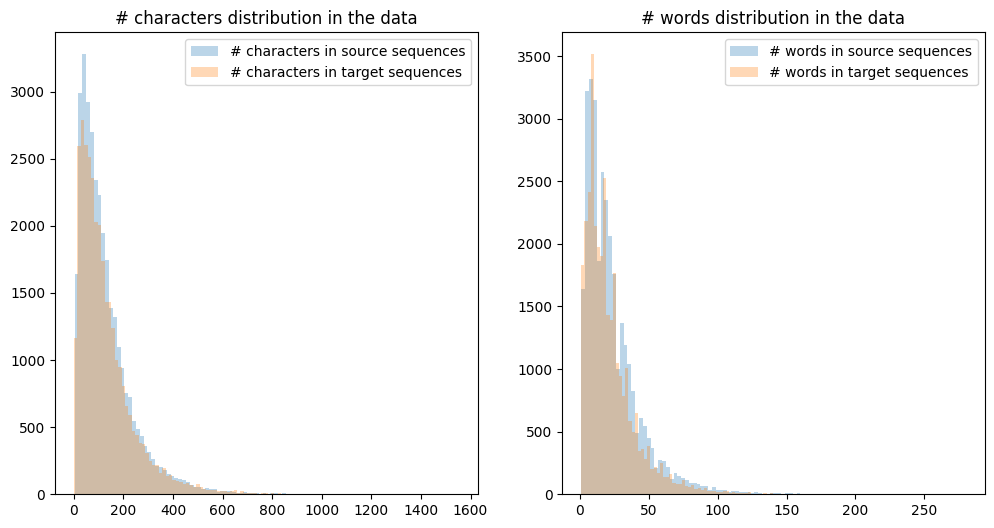

In [17]:
# distribution of character and words numbers --> to identify an efficient min and max number of characters / words
length_sources_char, length_target_char, length_sources_words, length_target_words = [] ,[],[],[]
for i in data:
    length_sources_char.append(len(i['translation']['en']))
    length_target_char.append(len(i['translation']['it']))

    length_sources_words.append(len(i['translation']['en'].split(' ')))
    length_target_words.append(len(i['translation']['it'].split(' ')))

plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title('# characters distribution in the data')
plt.hist(length_sources_char, bins = 100,alpha = 0.3, label= '# characters in source sequences')
plt.hist(length_target_char, bins = 100, alpha = 0.3, label= '# characters in target sequences')
plt.legend()
plt.subplot(1,2,2)
plt.title('# words distribution in the data')
plt.hist(length_sources_words, bins = 100,alpha = 0.3, label= '# words in source sequences')
plt.hist(length_target_words, bins = 100, alpha = 0.3, label= '# words in target sequences')

plt.legend()
plt.show()

In [18]:
def filter_data(data, min_number, max_number, lang1, lang2, method = 'characters'):
    assert method in ['characters', 'words']
    out = []
    n_rows_start = len(data)
    for d in data:
        if method == 'characters':
            l1 = len(d['translation'][lang1])
            l2 = len(d['translation'][lang2])
            if l1>min_number and l2>min_number and l1 < max_number and  l2<max_number:
                out.append({'translation':{lang1:d['translation'][lang1],  lang2:d['translation'][lang2]}})

        elif method == 'words':
            l1 = len(d['translation'][lang1].split(' '))
            l2 = len(d['translation'][lang2].split(' '))

            if l1>min_number and l2>min_number and l1 < max_number and  l2<max_number:
                out.append({'translation':{lang1:d['translation'][lang1],  lang2:d['translation'][lang2]}})

            
    
    n_rows_end = len(out)
    print(f"Started with {n_rows_start} row. {n_rows_end} are left")

    return out

In [19]:
data_filtered = filter_data(data, min_number = 50, max_number= 500, lang1 = 'en', lang2 ='it', method = 'characters')

Started with 32332 row. 22531 are left


In [20]:
# func to build the tokenizer
def build_tokenizer(all_sentences , tokenizer_path_out = None):
    tokenizer = Tokenizer(WordLevel(unk_token= "[UNK]")) # 
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
    tokenizer.train_from_iterator(all_sentences, trainer=trainer)
    return tokenizer

# func to retrieve data 
def retrieve_data(lang1  , lang2 , filter_range, method ):
    lang1_data, lang2_data = [], []
    # load data
    data = load_dataset('opus_books', f'{lang1}-{lang2}', split = 'train')

    # filter the data remove too short and too long sentences
    if filter_range != None:
        data = filter_data(data, min_number = filter_range[0], max_number= filter_range[1], lang1 = 'en', lang2 ='it', method = method)
    for row in data:
        lang1_data.append(row['translation'][lang1])
        lang2_data.append(row['translation'][lang2])
    
    return lang1_data, lang2_data

# func to retrieve data and fit tokenizer
def create_tokenizer_and_corpus_train_test(lang1 , lang2 , train_split = 0.9, filter_range = None, method = 'words'):
    """
    Return dict:
        - trained tokenizer on source text (lang1)
        - trained tokenizer on target text (lang2)
        - source text corpus (train, validation)
        - target text corpus (train, validation)
    """
    # retrice the two corpuses 
    source_text_corpus, target_text_corpus =  retrieve_data(lang1 = lang1 , lang2= lang2 , filter_range = filter_range, method = method)

    # fit tokenizers
    source_tokenizer = build_tokenizer(all_sentences = source_text_corpus)
    target_tokenizer = build_tokenizer(all_sentences = target_text_corpus)

    # Crate train / val split 
    train_val_split = int(len(source_text_corpus) * train_split )

    # Shuffle the data
    indexes = list(range(len(source_text_corpus)))                        
    random.shuffle(indexes)                                                
    source_text_corpus = [source_text_corpus[i] for i in indexes]         
    target_text_corpus = [target_text_corpus[i] for i in indexes]         

    source_text_corpus_train = source_text_corpus[:train_val_split]
    source_text_corpus_val = source_text_corpus[train_val_split:]

    target_text_corpus_train = target_text_corpus[:train_val_split]
    target_text_corpus_val = target_text_corpus[train_val_split:]
    
    data = {"source_tokenizer":source_tokenizer, 
            "target_tokenizer": target_tokenizer , 
            "source_train_set":source_text_corpus_train, 
            "source_val_set":  source_text_corpus_val,
            "target_train_set" :  target_text_corpus_train,
            "target_val_set": target_text_corpus_val}

    return data


tokenizers_n_data = create_tokenizer_and_corpus_train_test(lang1 = 'en', lang2 = 'it', train_split= 0.9)

In [21]:
class TranslationDataset(Dataset):
    def __init__(self, 
                 source_tokenizer, 
                 target_tokenizer,  
                 source_corpus, 
                 target_corpus, 
                 source_seq_length, 
                 target_seq_length):
        super().__init__()

        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.source_corpus = source_corpus
        self.target_corpus = target_corpus
        self.source_seq_length = source_seq_length
        self.target_seq_length = target_seq_length

        self.sos_token = torch.tensor([source_tokenizer.token_to_id('[SOS]')], dtype= torch.int64)
        self.eos_token = torch.tensor([source_tokenizer.token_to_id('[EOS]')], dtype= torch.int64)
        self.pad_token = torch.tensor([source_tokenizer.token_to_id('[PAD]')], dtype= torch.int64)

    def __len__(self):
        return len(self.source_corpus)
    
    def __getitem__(self, index):
        source_text = self.source_corpus[index]
        target_text = self.target_corpus[index]

        enc_input_ids = self.source_tokenizer.encode(source_text).ids
        dec_input_ids = self.target_tokenizer.encode(target_text).ids

        enc_padding = self.source_seq_length - len(enc_input_ids) - 2 
        dec_padding = self.source_seq_length - len(dec_input_ids) - 1

        encoder_input = torch.cat([
            self.sos_token,
            torch.tensor(enc_input_ids, dtype= torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * enc_padding , dtype = torch.int64 )
        ])

        decoder_input = torch.cat([
            self.sos_token,
            torch.tensor(dec_input_ids, dtype= torch.int64),
            torch.tensor([self.pad_token] * dec_padding , dtype = torch.int64 )
        ])

        decoder_output = torch.cat([
            torch.tensor(dec_input_ids, dtype= torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * dec_padding , dtype = torch.int64 ),
        ])
        
        return (encoder_input , decoder_input, decoder_output)

In [22]:
# Check the max senquence length for source and target
max_source_seq_length = max([len(tokenizers_n_data['source_tokenizer'].encode(i).ids) for i in tokenizers_n_data['source_train_set']])
max_target_seq_length = max([len(tokenizers_n_data['target_tokenizer'].encode(i).ids)  for i in tokenizers_n_data['target_train_set']])
max_source_seq_length, max_target_seq_length

(309, 274)

In [23]:
train_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_train_set'],
                                target_corpus= tokenizers_n_data['target_train_set'],
                                source_seq_length =  max_source_seq_length ,
                                target_seq_length = max_target_seq_length  )

val_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_val_set'],
                                target_corpus= tokenizers_n_data['target_val_set'],
                                source_seq_length =  max_source_seq_length ,
                                target_seq_length = max_target_seq_length  )


# test the code
train_batch_size, val_batch_size = 5, 2

train_data_loader = DataLoader(train_data ,batch_size=train_batch_size ,shuffle= True)
val_data_loader = DataLoader(val_data ,batch_size=val_batch_size ,shuffle= False)

# check one batch of the val_data_loader
for i in val_data_loader:
    print(len(i)) # we should have (encoder_input , decoder_input, decoder_output), so length of 3
    print(i[0].shape) # (batch , max_length_source)
    print(i[2])  # decoder_output tokens list
    break

3
torch.Size([2, 309])
tensor([[ 3405,   175,   225,  1721,   376,    13,   254,    23,   202,    17,
           500,   235,   165,   891,     0,   122,    45,    50, 12443,     5,
             3,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,

# Train loop

In [24]:
# train function
def train(model, 
          train_loader, 
          val_loader, 
          epochs, 
          lr,
          patience, 
          target_tokenizer, 
          device,
          model_folder = None ):
    
    # setting the loss function
    loss = nn.CrossEntropyLoss(ignore_index=target_tokenizer.token_to_id('[PAD]'), label_smoothing = 0.1)  # ignore padding when calculating the loss
    model.to(device)
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr= lr,  eps=1e-9)
    min_val_loss = 100
    epochs_no_improvement = 0
    train_loss, val_loss = [], []
    model_save_loss = {}
    for epoch in range(1, epochs +1 ):
        print(f'Epoch {epoch}')

        # train loop
        total_row = 0 
        epoch_train_loss = []
        model.train()
        for batch in train_loader:
            
            encoder_input , decoder_input, decoder_output = batch

            total_row += encoder_input.shape[0]
            encoder_input = encoder_input.to(device)
            decoder_input = decoder_input.to(device)
            decoder_output = decoder_output.to(device)  #(N, max_sentence_length)
            
            # make predictions --> (N, max_sentence_length, vocab_size_target)
            pred = model(encoder_input, decoder_input)  # source, target
            
            # Change shape of pred to (N*max_sentence_length, vocab_size_target)
            pred = pred.view(-1 , target_tokenizer.get_vocab_size())

            loss_batch = loss(pred, decoder_output.view(-1))  # decoder_output changed from (N, max_sentence_length) to (N*max_sentence_length)

            # Backpropagate the loss
            loss_batch.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            epoch_train_loss.append(loss_batch.detach().cpu().numpy())
        mean_epoch_loss = round(np.sum(epoch_train_loss) / total_row, 4) 
        train_loss.append(mean_epoch_loss)

        # Evaluation loop
        epoch_val_loss = []
        model.eval()
        with torch.no_grad():
            total_row = 0

            for batch in val_loader:
                encoder_input , decoder_input, decoder_output = batch
                total_row += encoder_input.shape[0]
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                decoder_output = decoder_output.to(device) #(N, max_sentence_length)

                # make predictions --> (N, max_sentence_length, vocab_size_target)
                pred = model(encoder_input, decoder_input)  # source, target

                # Change shape pred to (N, vocab_size_target)
                pred = pred.view(-1 , target_tokenizer.get_vocab_size())

                loss_batch = loss(pred, decoder_output.view(-1))
                epoch_val_loss.append(loss_batch.detach().cpu().numpy())

        mean_epoch_loss = round(np.sum(epoch_val_loss) / total_row, 4) 
        val_loss.append(mean_epoch_loss)

        # if the loss did not improve for patience epochs, interupt training 
        if val_loss[-1] < min_val_loss:
            epochs_no_improvement= 0
            min_val_loss = val_loss[-1]
        else: 
            epochs_no_improvement +=1

        print(f'Train loss: {train_loss[-1]}')
        print(f'Validation loss: {val_loss[-1]}')

        # save the model every 2 epochs
        if model_folder != None :
            if epoch % 2 == 0:
                if not os.path.exists(model_folder) :
                    os.makedirs(model_folder)

                model_path = model_folder +'/epoch_' +str(epoch) + '.pth'
                torch.save(model.state_dict() ,model_path)
                model_save_loss[model_path] = val_loss[-1]


        print(f"epochs with no improvement {epochs_no_improvement}")
        if epochs_no_improvement == patience:
            break
        
    # plot losses and save the plot 
    plt.plot( range(1, len(train_loss)+1),train_loss, label = 'train loss', color = 'red')
    plt.plot( range(1, len(val_loss)+1), val_loss,label = 'val loss', color = 'green')
    plt.legend()
    if model_folder != None :
        plt.savefig(model_folder + '/losses.png')
    plt.show()

    # remove all saved models except the one with lowest validation loss
    index_min = min(list(model_save_loss.values()))
    best_model_path = [i for i in model_save_loss.keys() if model_save_loss[i] == index_min][0]
    for f in model_save_loss.keys():
        if f != best_model_path:
            os.remove(f)

    return model, train_loss, val_loss

# Put everything together

In [25]:
# Retrieve data, fit tokenizer, split in train and val
config = {'train_split':0.9, 
          'filter_range' :[5,500], 
          'method': 'characters'}

tokenizers_n_data = create_tokenizer_and_corpus_train_test(lang1 = 'en', lang2 = 'it', 
                                                           train_split= config['train_split'], 
                                                           filter_range = config['filter_range'], 
                                                           method = config['method'])

# Assertions 
assert tokenizers_n_data['source_tokenizer'].token_to_id('[SOS]')  == tokenizers_n_data['target_tokenizer'].token_to_id('[SOS]')
assert tokenizers_n_data['source_tokenizer'].token_to_id('[EOS]')  == tokenizers_n_data['target_tokenizer'].token_to_id('[EOS]')
assert tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]')  == tokenizers_n_data['target_tokenizer'].token_to_id('[PAD]')

# Calculate the max sequence length
max_source_seq_length = max([len(tokenizers_n_data['source_tokenizer'].encode(i).ids) for i in tokenizers_n_data['source_train_set']])  
max_target_seq_length = max([len(tokenizers_n_data['target_tokenizer'].encode(i).ids) for i in tokenizers_n_data['target_train_set']]) 

# max length = max(source_length , target_length)
max_length = max(max_source_seq_length, max_target_seq_length)  + 2 # set to the same sequence length
print('max_source_seq_length: ', max_source_seq_length)
print('max_target_seq_length: ', max_target_seq_length)
print('max_length: ', max_length)

# update config file
config['max_length'] = max_length


# Create train and val datasets
train_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer = tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_train_set'],
                                target_corpus= tokenizers_n_data['target_train_set'],
                                source_seq_length =  config['max_length'] ,
                                target_seq_length = config['max_length']  )

val_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_val_set'],
                                target_corpus= tokenizers_n_data['target_val_set'],
                                source_seq_length = config['max_length'] ,
                                target_seq_length = config['max_length'] )


# Create train and validation DataLoaders
config['train_batch_size'] = 15
config['val_batch_size'] = 5

train_data_loader = DataLoader(train_data , batch_size=config['train_batch_size'] ,shuffle= False)
val_data_loader = DataLoader(val_data ,batch_size=config['val_batch_size']  ,shuffle= False)

# Hyperparams
source_vocab_size = tokenizers_n_data['source_tokenizer'].get_vocab_size()
target_vocab_size = tokenizers_n_data['target_tokenizer'].get_vocab_size()
source_pad_index, target_pad_index = tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]') , tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]')

# set the params for transformer
config.update({ 'embed_size' : 1024,
                'num_layers' : 6,
                'heads' :16,
                'device' :'cuda',
                'expansion' :4,
                'dropout':0.3,
                'learning_rate': 0.0001})


# Instantiate Transformer model
transformermodel  = Transformer(target_vocab_size = target_vocab_size, 
                                source_vocab_size = source_vocab_size ,
                                target_pad_index = target_pad_index,
                                source_pad_index = source_pad_index,
                                embed_size = config['embed_size'], 
                                num_layers = config['num_layers'],
                                heads =  config['heads'],
                                device = config['device'],
                                expansion = config['expansion'],
                                dropout =  config['dropout'],
                                max_sentence_length = config['max_length'])

n_params = count_parameters(transformermodel)

Started with 32332 row. 31303 are left
max_source_seq_length:  120
max_target_seq_length:  108
max_length:  122
Model parameters (millions): 256


Epoch 1
Train loss: 0.4845
validation loss: 1.2045
epochs with no improvement 0
Epoch 2
Train loss: 0.3968
validation loss: 1.1473
epochs with no improvement 0
Epoch 3
Train loss: 0.3694
validation loss: 1.1205
epochs with no improvement 0
Epoch 4
Train loss: 0.35
validation loss: 1.0997
epochs with no improvement 0
Epoch 5
Train loss: 0.3342
validation loss: 1.0859
epochs with no improvement 0
Epoch 6
Train loss: 0.3209
validation loss: 1.0754
epochs with no improvement 0
Epoch 7
Train loss: 0.3088
validation loss: 1.0705
epochs with no improvement 0
Epoch 8
Train loss: 0.298
validation loss: 1.0655
epochs with no improvement 0
Epoch 9
Train loss: 0.2876
validation loss: 1.0681
epochs with no improvement 1
Epoch 10
Train loss: 0.2779
validation loss: 1.0695
epochs with no improvement 2
Epoch 11
Train loss: 0.269
validation loss: 1.0737
epochs with no improvement 3
Epoch 12
Train loss: 0.2607
validation loss: 1.0746
epochs with no improvement 4
Epoch 13
Train loss: 0.2527
validation lo

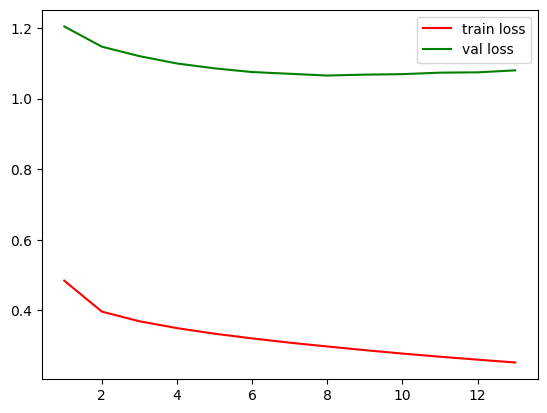

In [ ]:
# specify the folder where to save trained model
folder_model_name = 'trained_models/params_'+ str(n_params) +'M'

# train the transformer and save best weights
trained_model_filt, _, _ = train(model=transformermodel,
                                train_loader=train_data_loader,
                                val_loader= val_data_loader,
                                epochs = 25,
                                lr = config['learning_rate'],
                                patience = 5,
                                target_tokenizer = tokenizers_n_data['target_tokenizer'],
                                device='cuda',
                                model_folder = folder_model_name)

# save config files:
with open(folder_model_name+'/config.json', 'w') as file:
    json.dump(config, file )

# Translate the validation set

In [ ]:
# specify the model to load 
folder_model = 'trained_models/params_256'

# load config file 
with open(folder_model+'/config.json', 'r') as file:
    config = json.load( file )

# tokenize the same data with same params. TODO save the tokenizer
tokenizers_n_data = create_tokenizer_and_corpus_train_test(lang1 = 'en', lang2 = 'it', 
                                                           train_split= config['train_split'], 
                                                           filter_range = config['filter_range'], 
                                                           method = config['method'])

# Hyperparams
source_vocab_size = tokenizers_n_data['source_tokenizer'].get_vocab_size()
target_vocab_size = tokenizers_n_data['target_tokenizer'].get_vocab_size()
source_pad_index, target_pad_index = tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]') , tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]')

val_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_val_set'],
                                target_corpus= tokenizers_n_data['target_val_set'],
                                source_seq_length = config['max_length'] ,
                                target_seq_length = config['max_length'] )

val_data_loader = DataLoader(val_data , batch_size = 10 ,shuffle= False)

Started with 32332 row. 31303 are left


In [36]:
# Instantiate the transformer model and load weights
trained_model  = Transformer(target_vocab_size = target_vocab_size, 
                                source_vocab_size = source_vocab_size ,
                                target_pad_index = target_pad_index,
                                source_pad_index = source_pad_index,
                                embed_size = config['embed_size'], 
                                num_layers = config['num_layers'],
                                heads =  config['heads'],
                                device = config['device'],
                                expansion = config['expansion'],
                                dropout =  config['dropout'],
                                max_sentence_length = config['max_length'])

# load weights
state_dict = torch.load(folder_model + '/' + [i for i in os.listdir(folder_model) if '.pth' in i][0])
trained_model.load_state_dict(state_dict)

<All keys matched successfully>

In [37]:
# Function to perfom translation
def translate(model, 
              tokenizers_source, 
              tokenizers_target, 
              device , 
              source_text,
              expected_translation,
              sequence_length: int):
    
    model.eval()
    sos_tok= tokenizers_source.token_to_id('[SOS]')
    eos_tok  = tokenizers_source.token_to_id('[EOS]')
    pad_tok = tokenizers_source.token_to_id('[PAD]')

    for (sentence, groundtruth) in zip(source_text, expected_translation):
        ids = tokenizers_source.encode(sentence).ids
        # print(ids)
        padding_enc = sequence_length - len(ids) - 2 
        padding_dec = sequence_length -  1 
        encoder_input = torch.cat([
                        torch.tensor([sos_tok], dtype= torch.int64),
                         torch.tensor(ids, dtype= torch.int64),
                         torch.tensor([eos_tok], dtype= torch.int64),
                         torch.tensor([pad_tok]* padding_enc, dtype= torch.int64)]).unsqueeze(0)
    
        #print(encoder_input.shape)

        decoder_input = torch.cat([torch.tensor([sos_tok], dtype= torch.int64),
                                     torch.tensor([pad_tok] * padding_dec, dtype= torch.int64)]).unsqueeze(0)
        
        #print(decoder_input.shape)
        # print(decoder_input)
        model = model.to(device)
        encoder_input = encoder_input.to(device)
        decoder_input = decoder_input.to(device)
        translation  = torch.zeros(1,  sequence_length)
        next_token_index = 0
        new_token = None
        while new_token != eos_tok:
            output = model(encoder_input, decoder_input)
            # print(output.shape)
            sliceoutput = output[:,next_token_index,:]
            # print(sliceoutput.shape)
            new_token = torch.argmax(sliceoutput)
            # print(new_token)
            #print(new_token)
            decoder_input[0, next_token_index+1] = new_token.item()
            #print(decoder_input)
            translation[0, next_token_index  ] = new_token
            #print(translation)
            next_token_index += 1

        #print(translation)
        print('-'*30)
        translation = tokenizers_target.decode(translation.detach().cpu().numpy().astype('int')[0])
        print('Original sentence:', sentence)
        print("Translation:", translation)
        print('expected tranlation:', groundtruth)


translate(model = trained_model, 
            tokenizers_source = tokenizers_n_data['source_tokenizer'], 
            tokenizers_target = tokenizers_n_data['target_tokenizer'], 
            device='cuda',
            source_text = tokenizers_n_data['source_val_set'][30:40],
            expected_translation = tokenizers_n_data['target_val_set'][30:40],
            sequence_length = config['max_length'])

------------------------------
Original sentence: "Oh, don't be a stupid ass!" said Harris's head. "I believe you did it on purpose."
Translation: — Ah , non ci ! — disse Harris . — Io ho un capo . — Io non lo vedo che avete fatto colazione .
expected tranlation: — Non far lo stupido! — disse la testa di Harris. — Voi certo l’avete fatto apposta.
------------------------------
Original sentence: Therefore, as I have said, a new prince in a new principality has always distributed arms.
Translation: E , come ho detto , sono sempre in uno principe nuovo principe nuovo sempre .
expected tranlation: Però, come io ho detto, uno principe nuovo in uno principato nuovo sempre vi ha ordinato l’arme.
------------------------------
Original sentence: It was the same with the socialistic books: they were either beautiful but inapplicable fancies which had carried him away when he was still at the university or they were improvements and patchings-up of the order existing in Europe, with which agric